# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts.

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input.

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1.


# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K.

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files

In [2]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [3]:
def image_generator(files, batch_size = 32, sz = (256, 256)):

  while True:

    #extract a random batch
    batch = np.random.choice(files, size = batch_size)

    #variables for collecting batches of inputs and outputs
    batch_x = []
    batch_y = []


    for f in batch:

        #get the masks. Note that masks are png files
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask
        mask[mask >= 2] = 0
        mask[mask != 0 ] = 1

        batch_y.append(mask)

        #preprocess the raw images
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)


In [4]:
batch_size = 32

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [5]:
x, y= next(train_generator)

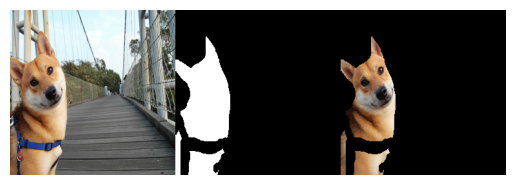

In [6]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow(np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [7]:
def mean_iou(y_true, y_pred):
    yt0 = tf.cast(y_true[:,:,:,0], 'float32') # Cast yt0 to float32
    yp0 = tf.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [8]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x

  #down sampling
  f = 8
  layers = []

  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64

  #bottleneck
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  #upsampling
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1


  #classification
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #model creation
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])

  return model

In [9]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions

In [10]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.keras', monitor='val_loss', verbose=0, save_best_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        #predict the mask
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1
        msk[msk < 0.5] = 0

        #show the mask and the segmented image
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

i= 1 loss= 0.5785853266716003 val_loss= 0.5576070547103882 mean_iou= 0.0014106049202382565 val_mean_iou= 0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


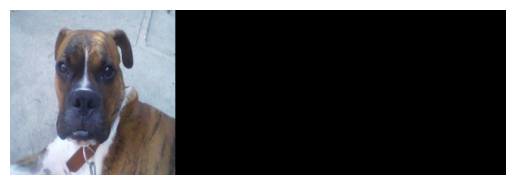

i= 2 loss= 0.5258995890617371 val_loss= 0.47620686888694763 mean_iou= 0.03656204044818878 val_mean_iou= 0.07156743854284286
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


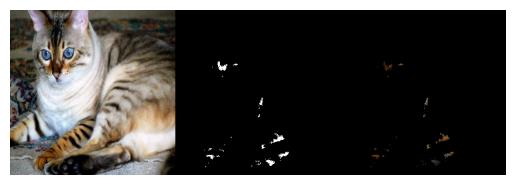

i= 3 loss= 0.47337326407432556 val_loss= 0.4308982193470001 mean_iou= 0.3555271029472351 val_mean_iou= 0.46730586886405945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


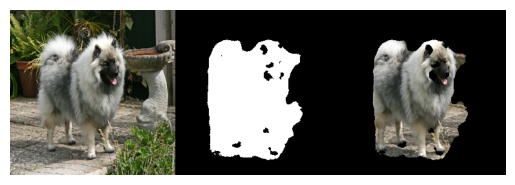

i= 4 loss= 0.4386206865310669 val_loss= 0.41567736864089966 mean_iou= 0.45344093441963196 val_mean_iou= 0.47832199931144714
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


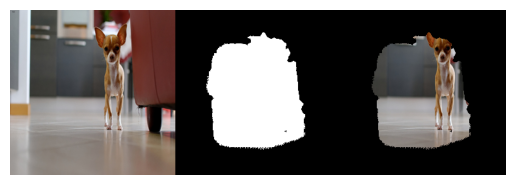

i= 5 loss= 0.4176948666572571 val_loss= 0.42766669392585754 mean_iou= 0.46611469984054565 val_mean_iou= 0.44920045137405396
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


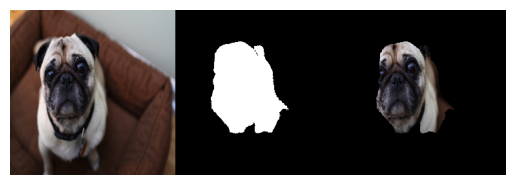

i= 6 loss= 0.3842765688896179 val_loss= 0.3511667251586914 mean_iou= 0.5214720368385315 val_mean_iou= 0.5960208773612976
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


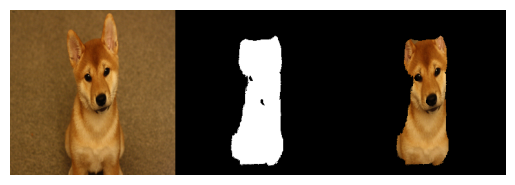

i= 7 loss= 0.34254151582717896 val_loss= 0.352519154548645 mean_iou= 0.5854488611221313 val_mean_iou= 0.6136460900306702
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


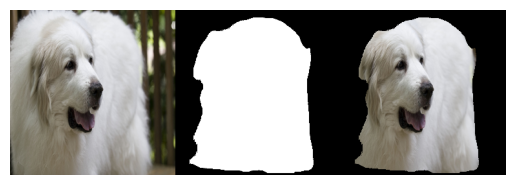

i= 8 loss= 0.3105751574039459 val_loss= 0.3129729926586151 mean_iou= 0.6258854269981384 val_mean_iou= 0.6574730277061462
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


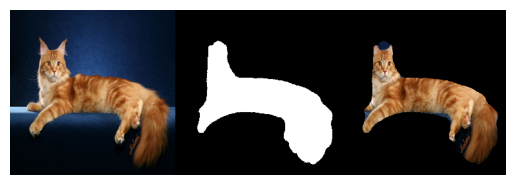

i= 9 loss= 0.287942498922348 val_loss= 0.27472570538520813 mean_iou= 0.6570566892623901 val_mean_iou= 0.6386058330535889
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


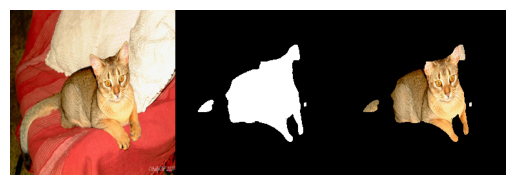

i= 10 loss= 0.2631535232067108 val_loss= 0.3027108311653137 mean_iou= 0.6826154589653015 val_mean_iou= 0.6700960397720337
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


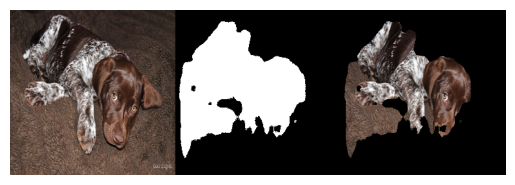

i= 11 loss= 0.24359050393104553 val_loss= 0.32574841380119324 mean_iou= 0.7077455520629883 val_mean_iou= 0.6009367108345032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


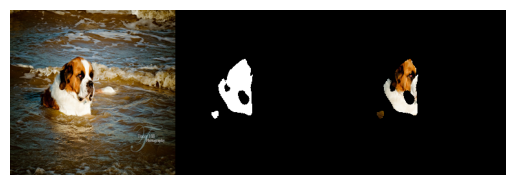

i= 12 loss= 0.23195567727088928 val_loss= 0.2216619998216629 mean_iou= 0.7243011593818665 val_mean_iou= 0.7361700534820557
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


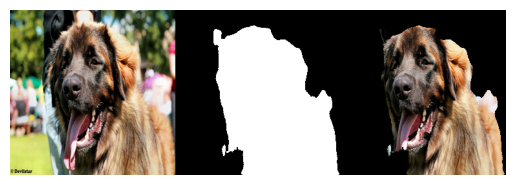

i= 13 loss= 0.2106633484363556 val_loss= 0.2835187613964081 mean_iou= 0.7476028800010681 val_mean_iou= 0.6748055815696716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


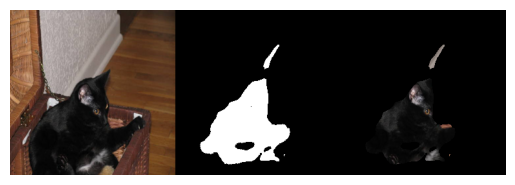

i= 14 loss= 0.20115070044994354 val_loss= 0.2314489483833313 mean_iou= 0.7581306099891663 val_mean_iou= 0.7517436742782593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


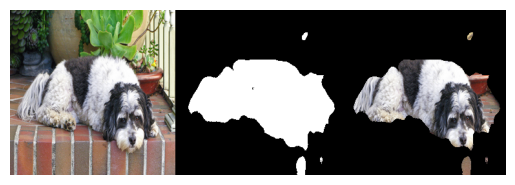

i= 15 loss= 0.18976080417633057 val_loss= 0.2162429392337799 mean_iou= 0.7742472887039185 val_mean_iou= 0.7376043796539307
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


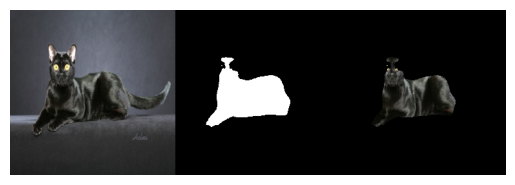

i= 16 loss= 0.17895744740962982 val_loss= 0.22221066057682037 mean_iou= 0.7808273434638977 val_mean_iou= 0.7390609979629517
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


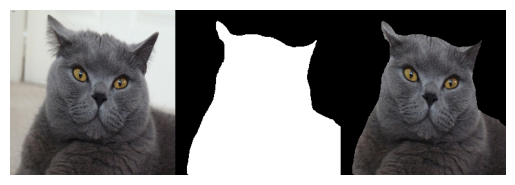

i= 17 loss= 0.16778862476348877 val_loss= 0.22165517508983612 mean_iou= 0.7960898280143738 val_mean_iou= 0.7475976943969727
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


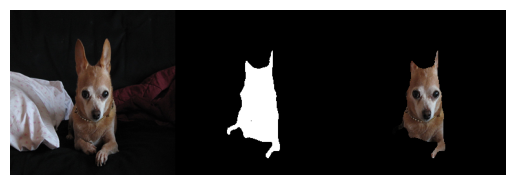

i= 18 loss= 0.16141456365585327 val_loss= 0.18947173655033112 mean_iou= 0.8032843470573425 val_mean_iou= 0.7758622765541077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


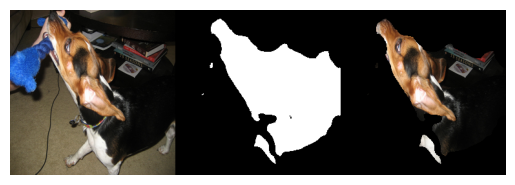

i= 19 loss= 0.15778565406799316 val_loss= 0.21243205666542053 mean_iou= 0.8064671754837036 val_mean_iou= 0.758470892906189
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


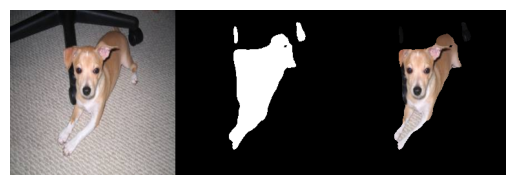

i= 20 loss= 0.14563579857349396 val_loss= 0.19432473182678223 mean_iou= 0.8184394240379333 val_mean_iou= 0.7499446868896484
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


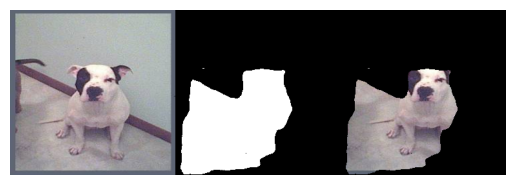

i= 21 loss= 0.14445792138576508 val_loss= 0.2438451647758484 mean_iou= 0.8237690925598145 val_mean_iou= 0.7350032329559326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


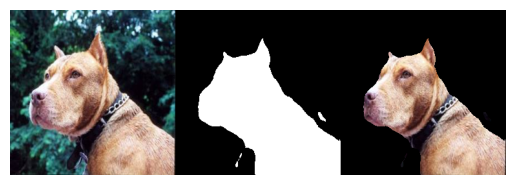

i= 22 loss= 0.1388600915670395 val_loss= 0.2310493141412735 mean_iou= 0.8297771215438843 val_mean_iou= 0.7319583892822266
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


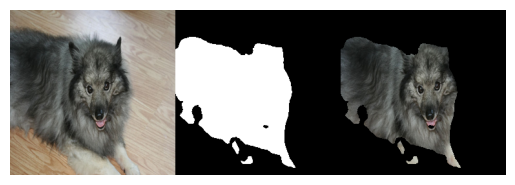

i= 23 loss= 0.12959952652454376 val_loss= 0.20536094903945923 mean_iou= 0.8370156288146973 val_mean_iou= 0.7748849391937256
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


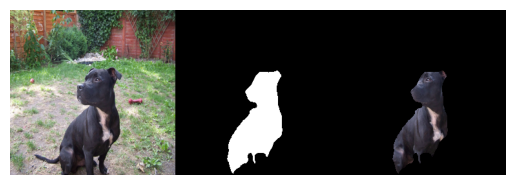

i= 24 loss= 0.128144770860672 val_loss= 0.19904638826847076 mean_iou= 0.8402226567268372 val_mean_iou= 0.7851685881614685
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


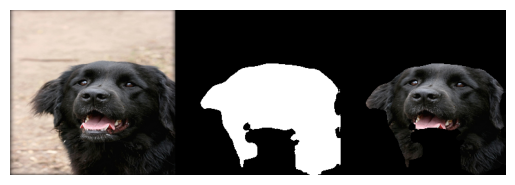

i= 25 loss= 0.12135227024555206 val_loss= 0.17786744236946106 mean_iou= 0.8478037714958191 val_mean_iou= 0.7921497821807861
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


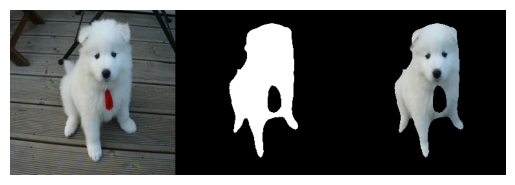

i= 26 loss= 0.11718065291643143 val_loss= 0.22040167450904846 mean_iou= 0.8518779873847961 val_mean_iou= 0.7696313261985779
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


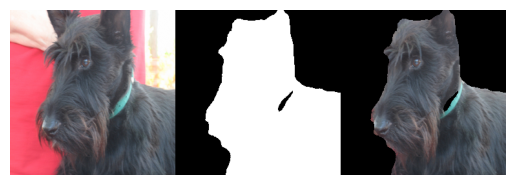

i= 27 loss= 0.11293549835681915 val_loss= 0.18015995621681213 mean_iou= 0.8548312783241272 val_mean_iou= 0.7766062021255493
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


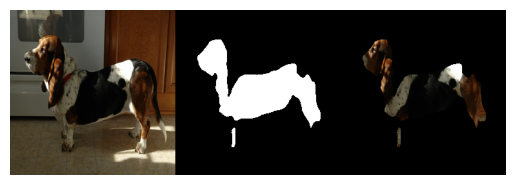

i= 28 loss= 0.11193881928920746 val_loss= 0.21124210953712463 mean_iou= 0.8574394583702087 val_mean_iou= 0.7725890874862671
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


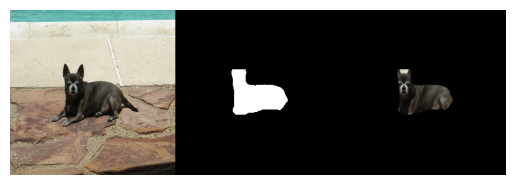

i= 29 loss= 0.10785762965679169 val_loss= 0.19128242135047913 mean_iou= 0.8624643087387085 val_mean_iou= 0.7911055088043213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


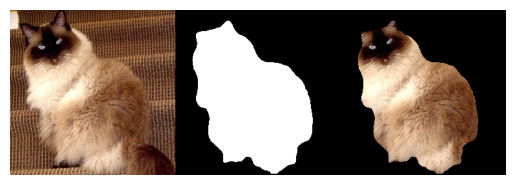

i= 30 loss= 0.10228709876537323 val_loss= 0.20869746804237366 mean_iou= 0.8689572215080261 val_mean_iou= 0.7938406467437744
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


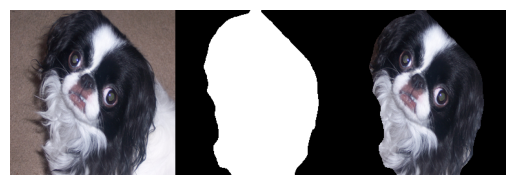

In [11]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator,
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [12]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2024-10-10 17:58:14--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.226.228.27, 13.226.228.57, 13.226.228.14, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.226.228.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.1s    

2024-10-10 17:58:14 (522 KB/s) - ‘test.jpg’ saved [63219/63219]



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


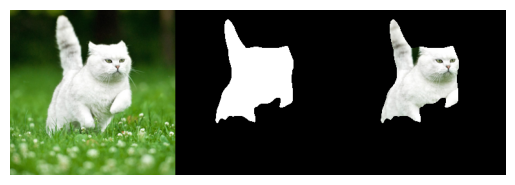

In [13]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#show the mask and the segmented image
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()